<a href="https://colab.research.google.com/github/thayyilakul/PyTorch-ML/blob/main/Pizza_steak_sushi_classifier_with_efficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [3]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
!pip install -q torchinfo
from torchinfo import summary
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 4393 (delta 1459), reused 1408 (delta 1401), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (2661/2661), done.
Updating files: 100% (248/248), done.


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [9]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f'{image_path} directory exists')
else:
  image_path.mkdir(parents = True, exist_ok = True)
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza steak sushi zip')
    f.write(request.content)

  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza steak sushi data...')
    zip_ref.extractall(image_path)

  os.remove(data_path / 'pizza_steak_sushi.zip')

Unzipping pizza steak sushi data...


In [10]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [11]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x781422c66920>,
 ['pizza', 'steak', 'sushi'])

In [13]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [14]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x781422f336d0>,
 ['pizza', 'steak', 'sushi'])

In [18]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

In [19]:
summary(model = model,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [20]:
for param in model.features.parameters():
  param.requires_grad = False

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280,
                    out_features = output_shape,
                    bias = True)
).to(device)

In [22]:
summary(model = model,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

end_timer = timer()
print(f'Total training time: {end_timer - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
Total training time: 202.938 seconds


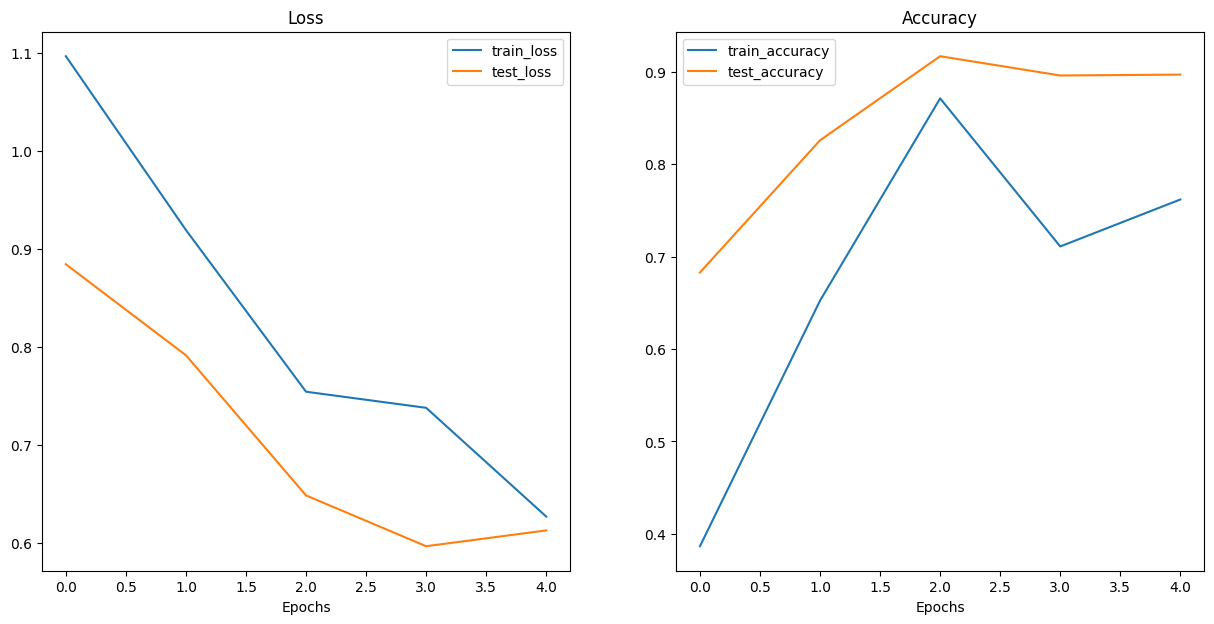

In [26]:
with open('helper_functions.py', 'wb') as f:
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  f.write(request.content)
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [27]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model, image_path, class_names, image_size = (224, 224), transform = None, device = device):
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
    ])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim = 0)
    target_image_pred = model(transformed_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
  plt.figure()
  plt.imshow(img)
  plt.title(f'Pred : {class_names[target_image_pred_label]} | Prob : {target_image_pred_probs.max():.3f}')
  plt.axis(False)

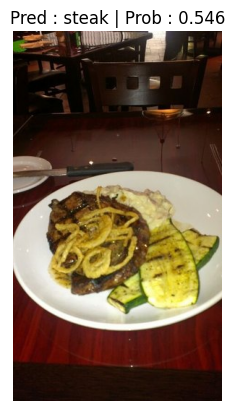

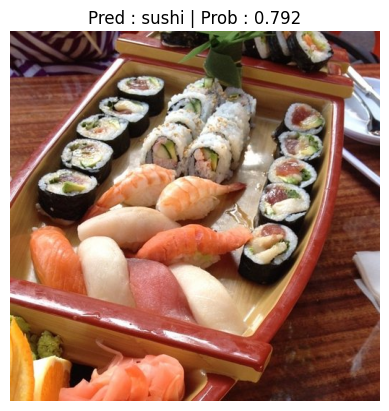

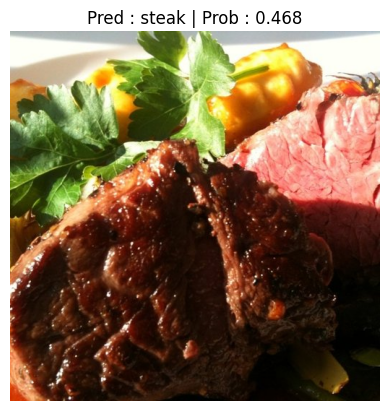

In [28]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population = test_image_path_list,
                                       k = num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224, 224))

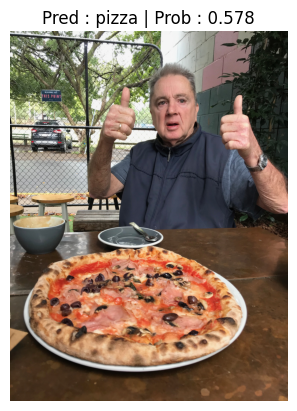

In [29]:
custom_image_path = data_path / '04-pizza-dad.jpeg'
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists')

pred_and_plot_image(model = model,
                      image_path = custom_image_path,
                      class_names = class_names,
                      image_size = (224, 224))